In [2]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 701626, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 701626 (delta 208), reused 71 (delta 71), pack-reused 701364 (from 3)
Receiving objects: 100% (701626/701626), 1.23 GiB | 35.97 MiB/s, done.
Resolving deltas: 100% (657101/657101), done.


In [18]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="pF3oH3TpEp2fEwjizlnt")
project = rf.workspace("mtuci-sasla").project("objects-on-surfaces")
version = project.version(6)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to Objects-on-surfaces-6 in yolov11:: 100%|██████████| 4238/4238 [00:00<00:00, 6354.41it/s]


In [24]:
import os, torch
import cv2 as cv
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils

TRAIN_PATH = "./Objects-on-surfaces-6/train/"
VALID_PATH = "./Objects-on-surfaces-6/valid/"

In [25]:
class ObjectDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.image_dir = os.path.join(files_dir, "images/")
        self.label_dir = os.path.join(files_dir, "labels/")
        self.height = height
        self.width = width

        self.images = [image for image in sorted(os.listdir(self.image_dir)) if image[-4:]=='.jpg']
        self.labels = [label for label in sorted(os.listdir(self.label_dir)) if label[-4:]=='.txt']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        img = cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB)
        img_res = cv.resize(img, (self.width, self.height), cv.INTER_AREA)
        img_res = Image.fromarray(img_res)

        annot_path = os.path.join(self.label_dir, self.labels[idx])
        img_boxes = []
        img_labels = []

        with open(annot_path, 'r') as file:
            for annot in file.read().splitlines():
                data = annot.split(" ")
                fdata = list(map(float, data))
                if len(fdata) > 5:
                    x_cords = fdata[1:-1:2]
                    y_cords = fdata[2:-2:2]
                    x_min = min(x_cords)
                    x_max = max(x_cords)
                    y_min = min(y_cords)
                    y_max = max(y_cords)
                else:
                    x_center = float(fdata[1]) * self.width
                    y_center = float(fdata[2]) * self.height
                    box_width = float(fdata[-2]) * self.width
                    box_height = float(fdata[-1]) * self.height
                    x_min = x_center - (box_width / 2)
                    x_max = x_center + (box_width / 2)
                    y_min = y_center - (box_height / 2)
                    y_max = y_center + (box_height / 2)

                img_labels.append(1 if (int(data[0]) == 0) else 2)
                img_boxes.append([x_min, y_min, x_max, y_max])

        image_id = torch.tensor([idx])
        img_labels = torch.as_tensor(img_labels, dtype=torch.int64)
        img_boxes = torch.as_tensor(img_boxes, dtype=torch.float32)
        area = None
        try:
          area = (img_boxes[:, 3] - img_boxes[:, 1]) * (img_boxes[:, 2] - img_boxes[:, 0])
        except:
          print(annot_path)
        iscrowd = torch.zeros((img_boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = img_boxes
        target["labels"] = img_labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = idx

        if self.transforms:
            img_res = self.transforms(img_res)

        return img_res, target

In [26]:
def get_model():
    model = fasterrcnn_resnet50_fpn(weights='COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)

    return model

In [27]:
def train(model):
    train_data = ObjectDataset(TRAIN_PATH, 640, 640, FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms())
    valid_data = ObjectDataset(VALID_PATH, 640, 640, FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms())

    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
    valid_data_loader = torch.utils.data.DataLoader(valid_data, batch_size=10, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(10):
        print(f"Epoch {epoch}")
        train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
        lr_scheduler.step()
        evaluate(model, valid_data_loader, device=device)

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model().to(device)
model.train()
train(model)

torch.save(model.state_dict(), './trained.pt')

Epoch 0
Epoch: [0]  [  0/148]  eta: 0:06:18  lr: 0.000039  loss: 1.8263 (1.8263)  loss_classifier: 1.3114 (1.3114)  loss_box_reg: 0.2680 (0.2680)  loss_objectness: 0.2024 (0.2024)  loss_rpn_box_reg: 0.0446 (0.0446)  time: 2.5558  data: 0.3908  max mem: 14096
Epoch: [0]  [ 10/148]  eta: 0:04:56  lr: 0.000379  loss: 1.3715 (1.4976)  loss_classifier: 1.0852 (0.9852)  loss_box_reg: 0.3005 (0.3095)  loss_objectness: 0.1538 (0.1585)  loss_rpn_box_reg: 0.0446 (0.0444)  time: 2.1487  data: 0.0688  max mem: 14413
Epoch: [0]  [ 20/148]  eta: 0:04:32  lr: 0.000719  loss: 0.9759 (1.1328)  loss_classifier: 0.4192 (0.6823)  loss_box_reg: 0.2913 (0.2931)  loss_objectness: 0.0769 (0.1236)  loss_rpn_box_reg: 0.0240 (0.0337)  time: 2.1045  data: 0.0356  max mem: 14414
Epoch: [0]  [ 30/148]  eta: 0:04:08  lr: 0.001058  loss: 0.6950 (0.9736)  loss_classifier: 0.3332 (0.5632)  loss_box_reg: 0.2559 (0.2790)  loss_objectness: 0.0522 (0.0999)  loss_rpn_box_reg: 0.0209 (0.0315)  time: 2.0864  data: 0.0344  max

In [ ]:
precis = [
    [0.408, 0.474, 0.477, 0.502, 0.505, 0.504, 0.507, 0.507, 0.506, 0.506],
    [0.669, 0.763, 0.776, 0.777, 0.778, 0.778, 0.779, 0.779, 0.778, 0.778],
    [0.439, 0.530, 0.526, 0.555, 0.561, 0.566, 0.566, 0.567, 0.566, 0.567],
    [0.235, 0.256, 0.246, 0.255, 0.255, 0.255, 0.257, 0.257, 0.257, 0.257],
    [0.370, 0.427, 0.429, 0.446, 0.448, 0.448, 0.451, 0.450, 0.449, 0.450],
    [0.489, 0.564, 0.590, 0.614, 0.616, 0.620, 0.620, 0.619, 0.619, 0.619]
]
recall = [
    [0.189, 0.202, 0.207, 0.215, 0.217, 0.217, 0.219, 0.219, 0.219, 0.219],
    [0.503, 0.539, 0.531, 0.554, 0.558, 0.556, 0.559, 0.560, 0.559, 0.559],
    [0.588, 0.611, 0.607, 0.631, 0.633, 0.629, 0.633, 0.634, 0.633, 0.633],
    [0.424, 0.453, 0.454, 0.465, 0.469, 0.468, 0.468, 0.468, 0.468, 0.468],
    [0.565, 0.587, 0.576, 0.593, 0.594, 0.595, 0.597, 0.597, 0.595, 0.595],
    [0.659, 0.682, 0.694, 0.720, 0.719, 0.717, 0.720, 0.719, 0.719, 0.719]
]

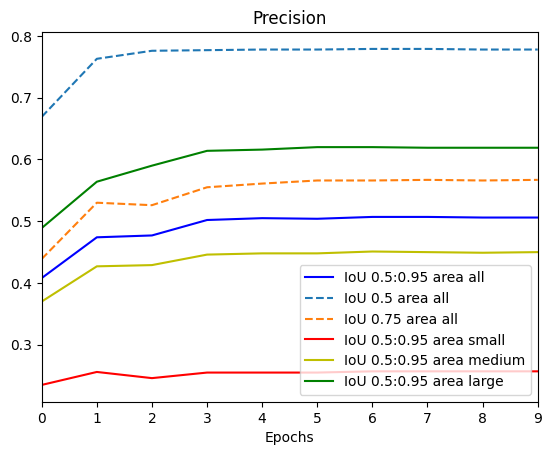

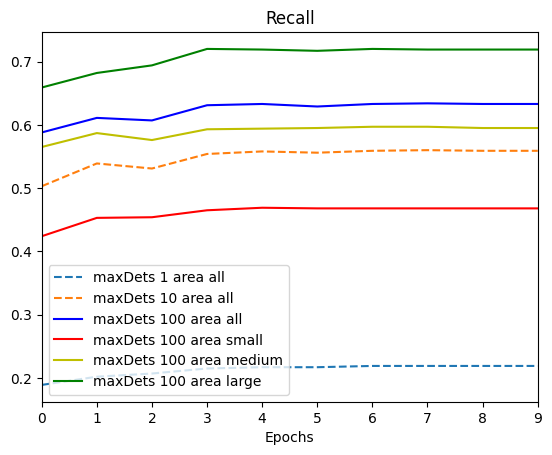

,Full,Small,Medium,Large
F1-score,0.562420,0.331796,0.512440,0.665263


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(np.arange(0, 10), precis[0], 'b', label="IoU 0.5:0.95 area all")
plt.plot(np.arange(0, 10), precis[1], '--', label="IoU 0.5 area all")
plt.plot(np.arange(0, 10), precis[2], '--', label="IoU 0.75 area all")
plt.plot(np.arange(0, 10), precis[3], 'r', label="IoU 0.5:0.95 area small")
plt.plot(np.arange(0, 10), precis[4], 'y', label="IoU 0.5:0.95 area medium")
plt.plot(np.arange(0, 10), precis[5], 'g', label="IoU 0.5:0.95 area large")
plt.xticks(np.arange(0, 10)), plt.margins(x=0)
plt.xlabel("Epochs"), plt.title("Precision"), plt.legend()
plt.show()

plt.plot(np.arange(0, 10), recall[0], '--', label="maxDets 1 area all")
plt.plot(np.arange(0, 10), recall[1], '--', label="maxDets 10 area all")
plt.plot(np.arange(0, 10), recall[2], 'b', label="maxDets 100 area all")
plt.plot(np.arange(0, 10), recall[3], 'r', label="maxDets 100 area small")
plt.plot(np.arange(0, 10), recall[4], 'y', label="maxDets 100 area medium")
plt.plot(np.arange(0, 10), recall[5], 'g', label="maxDets 100 area large")
plt.xticks(np.arange(0, 10)), plt.margins(x=0)
plt.xlabel("Epochs"), plt.title("Recall"), plt.legend()
plt.show()

df = pd.DataFrame({
    "Full":   [(2*precis[0][9]*recall[2][9])/(precis[0][9]+recall[2][9])],
    "Small":  [(2*precis[3][9]*recall[3][9])/(precis[3][9]+recall[3][9])],
    "Medium": [(2*precis[4][9]*recall[4][9])/(precis[4][9]+recall[4][9])],
    "Large":  [(2*precis[5][9]*recall[5][9])/(precis[5][9]+recall[5][9])]
})
df.style.relabel_index(["F1-score"], axis=0)

In [62]:
TEST_PATH = "./Objects-on-surfaces-6/test/"
test_data = ObjectDataset(TEST_PATH, 640, 640, FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms())
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

evaluate(model, test_data_loader, device=device)

creating index...
index created!
Test:  [ 0/22]  eta: 0:00:29  model_time: 0.9055 (0.9055)  evaluator_time: 0.0110 (0.0110)  time: 1.3603  data: 0.3976  max mem: 14416
Test:  [21/22]  eta: 0:00:00  model_time: 0.8470 (0.8313)  evaluator_time: 0.0305 (0.0278)  time: 0.9080  data: 0.0332  max mem: 14416
Test: Total time: 0:00:20 (0.9309 s / it)
Averaged stats: model_time: 0.8470 (0.8313)  evaluator_time: 0.0305 (0.0278)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.809
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ Io